In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import random
import seaborn as sns
import itertools as it
import pulp
import time
from metric_voting import *

%load_ext autoreload
%autoreload 2

In [2]:
colors = ["#0099cd","#ffca5d","#00cd99","#99cd00","#cd0099","#9900cd","#8dd3c7",
        "#bebada","#fb8072","#80b1d3","#fdb462","#b3de69","#fccde5","#bc80bd",
        "#ccebc5","#ffed6f","#ffffb3","#a6cee3","#1f78b4","#b2df8a","#33a02c",
        "#fb9a99","#e31a1c","#fdbf6f","#ff7f00","#cab2d6","#6a3d9a","#b15928",
        "#64ffda","#00B8D4","#A1887F","#76FF03","#DCE775","#B388FF","#FF80AB",
        "#D81B60","#26A69A","#FFEA00","#6200EA",
    ]
colors2 = colors[:6] + colors[-12::2]
custom_colors = ListedColormap(colors2)

In [12]:
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 18
})

### Generate Profile

In [3]:
# Choose number of voters n and the number of candidates m
n = 100
m = 1000

# Choose the number of winners for the election
k = 4

In [4]:
# Means and standard deviations for each of the two voter distributions
means = [[0, -2], [0, 2]]
stds = [0.5, 0.5]
two_party_G = [50,50]  # Group Sizes

# Create a list of voter parameters -- with each set of parameters being a dict
voter_params = [{'loc': None, 'scale': None, 'size': 2} for _ in range(len(two_party_G))]
for i,mean in enumerate(means):
    voter_params[i]['loc'] = mean

for i,std in enumerate(stds):
    voter_params[i]['scale'] = std
    
# Define the single set of candidate paramters
candidate_params = [{'low': -5, 'high': 5, 'size': 2}]

# define a distance function between voters and candidates
distance = lambda point1, point2: np.linalg.norm(point1 - point2)

# Create the group spatial generator object!
two_party_generator = GroupSpatial(n_voter_groups = 2, n_candidate_groups = 1,
                                   voter_dist_fns = [np.random.normal]*len(two_party_G),
                                   voter_dist_fn_params = voter_params,
                                   candidate_dist_fns = [np.random.uniform],
                                   candidate_dist_fn_params = candidate_params,
                                   distance_fn = distance)

In [5]:
np.random.seed(918717)

In [6]:
# Now each call .generate() will make a profile with random candidate and voter positions
profile, \
candidate_positions, \
voter_positions, \
voter_labels = two_party_generator.generate(voter_group_sizes = two_party_G, 
                                            candidate_group_sizes = [m])

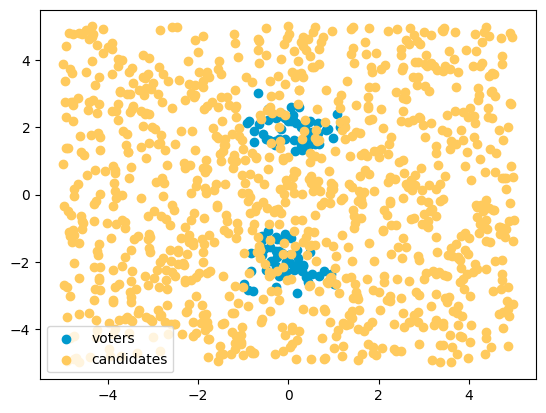

In [8]:
# visualize the results
pal = sns.color_palette("hls", 8)
plt.scatter(voter_positions[:,0], voter_positions[:,1], label = 'voters', color = colors[0])
plt.scatter(candidate_positions[:,0], candidate_positions[:,1], label = 'candidates', color = colors[1])
plt.legend()

### Elections and Worst Bloc results

In [9]:
# Collect results for different blocs and their representatives
n_samples = 100000
result_dict = {'voters' : voter_positions, 'candidates' : candidate_positions}
cst_array = euclidean_cost_array(voter_positions, candidate_positions)
elections_dict = {Bloc:{}, Borda:{}, STV:{'transfer_type' : 'weighted-fractional'}}

In [ ]:
for E, params in elections_dict.items():
    e_dict = {}
    name = E.__name__
    winners = E(**params).elect(profile,k)
    winner_mask = np.zeros(m, dtype=bool)
    winner_mask[winners] = True
    e_dict['winners'] = winner_mask
    
    bloc_label = 1
    # single group ineff
    group_mask = voter_labels
    group_reps1 = proportional_assignment(cst_array[winners, :], group_mask, bloc_label, k)
    group_reps2 = proportional_assignment(cst_array[winners, :], group_mask, 1 - bloc_label, k)
    group_rep_mask1 = np.zeros(m, dtype=bool)
    group_rep_mask2 = np.zeros(m, dtype=bool)
    group_rep_mask1[winners[group_reps1]] = True
    group_rep_mask2[winners[group_reps2]] = True
    group_ineff1 = group_inefficiency(cst_array, winners, group_mask, bloc_label)
    group_ineff2 = group_inefficiency(cst_array, winners, group_mask, 1 - bloc_label)
    
    if group_ineff1 > group_ineff2:
        e_dict['group'] = {
            'labels' : group_mask,
            'reps' : group_rep_mask1,
            'ineff' : group_ineff1
        }
    else:
        e_dict['group'] = {
            'labels' : 1 - group_mask,
            'reps' : group_rep_mask2,
            'ineff' : group_ineff2
        }

    # overall group ineff
    overall_mask = np.ones(n, dtype = int)
    overall_reps = proportional_assignment(cst_array[winners, :], overall_mask, bloc_label, k)
    overall_rep_mask = np.zeros(m, dtype=bool)
    overall_rep_mask[winners[overall_reps]] = True
    overall_ineff = group_inefficiency(cst_array, winners, overall_mask, bloc_label)
    e_dict['overall'] = {
        'labels' : overall_mask,
        'reps' : overall_rep_mask,
        'ineff' : overall_ineff
    }

    # heuristic group ineff 
    heuristic_bloc = heuristic_worst_bloc(cst_array, winners)
    heuristic_mask = np.zeros(n, dtype = int)
    heuristic_mask[heuristic_bloc] = 1
        
    heuristic_reps = proportional_assignment(cst_array[winners, :], heuristic_mask, bloc_label, k)
    heuristic_rep_mask = np.zeros(m, dtype=bool)
    heuristic_rep_mask[winners[heuristic_reps]] = True
    heuristic_ineff = group_inefficiency(cst_array, winners, heuristic_mask, bloc_label)
    e_dict['heuristic'] = {
        'labels' : heuristic_mask,
        'reps' : heuristic_rep_mask,
        'ineff' : heuristic_ineff
    }

    # random group ineff
    (worst_estimate, 
     worst_estimate_bloc) = worst_random_group_inefficiency(
         n_samples = n_samples,
         cost_arr = cst_array,
         winner_indices = winners,
         weights = np.ones(n)/n
     )
    random_mask = np.zeros(n, dtype = int)
    random_mask[worst_estimate_bloc] = 1
    random_reps = proportional_assignment(cst_array[winners, :], random_mask, bloc_label, k)
    random_rep_mask = np.zeros(m, dtype=bool)
    random_rep_mask[winners[random_reps]] = True
    random_ineff = worst_estimate
    e_dict['random'] = {
        'labels' : random_mask,
        'reps' : random_rep_mask,
        'ineff' : random_ineff
    }
    
    result_dict[name] = e_dict

In [10]:
f = '../data/data/2bloc_worst_example2.npz'
loaded_data = np.load(f, allow_pickle = True)
worst_bloc_dict = {key: loaded_data[key] for key in loaded_data.files}

for ky,vl in worst_bloc_dict.items():
    if ky not in ['voters', 'candidates']:
        worst_bloc_dict[ky] = vl.item()

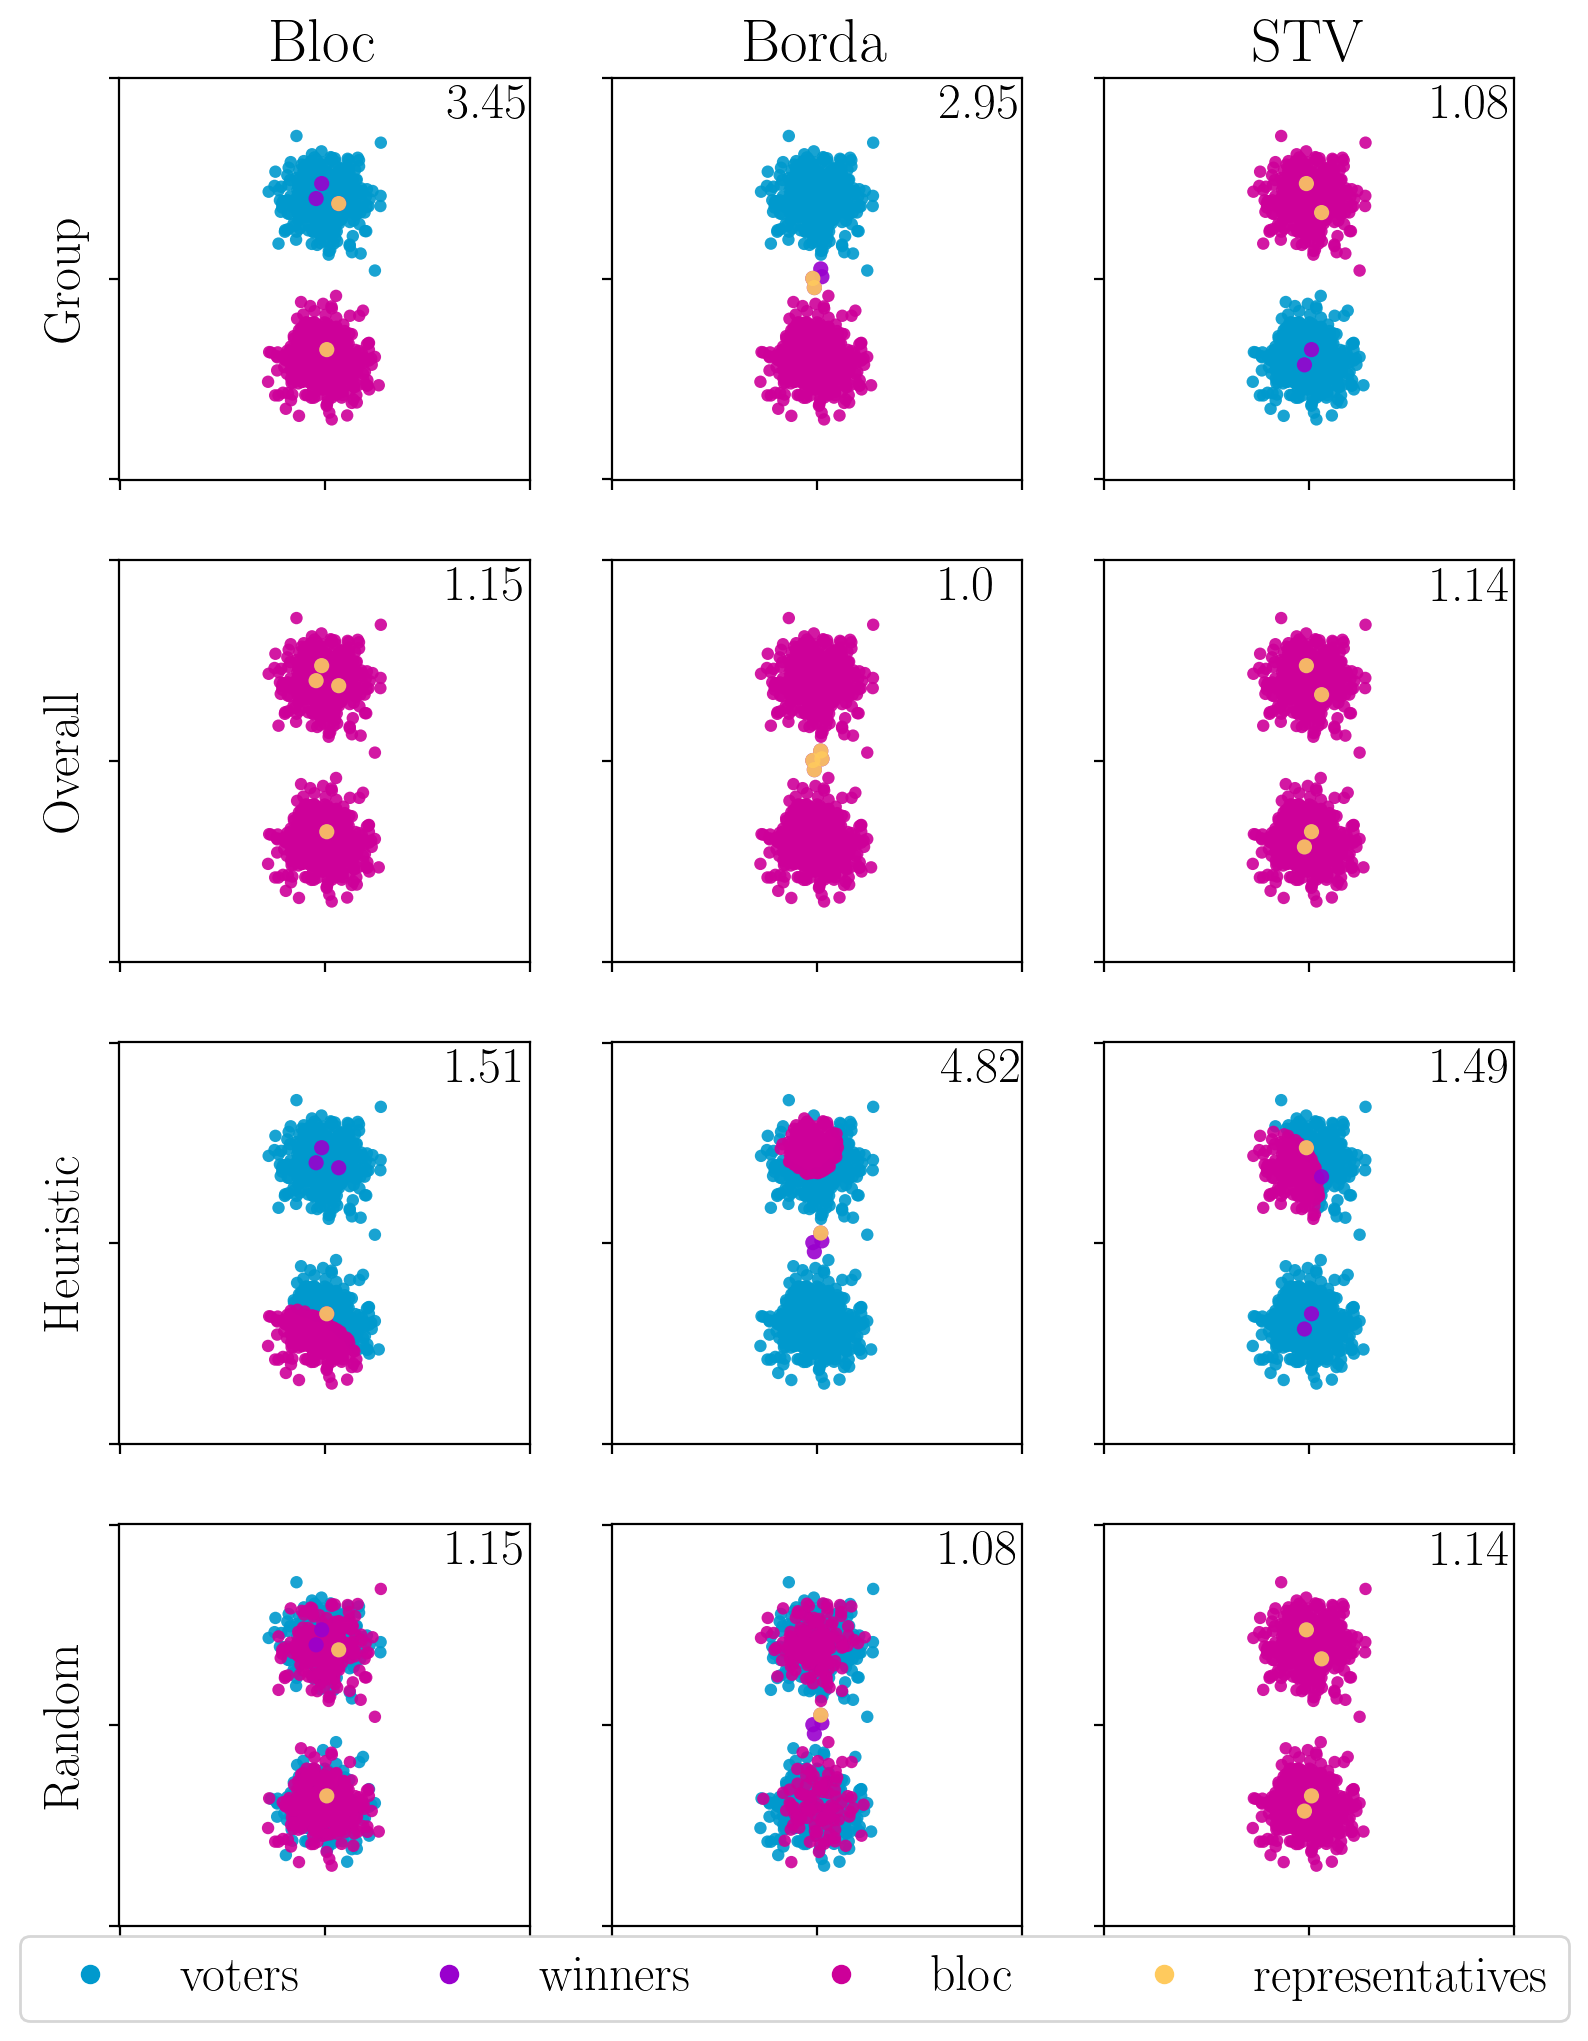

In [13]:
plot_representatives(
    results = worst_bloc_dict,
    fig_params = {'figsize' : (9, 12), 'dpi' : 200},
    colors = [colors[0], colors[-2], colors[5], colors[4], colors[1]],
    output_file = '../figures/2bloc_representatives2.png'
)

In [ ]:
worst_greedy_ineff, \
worst_greedy_bloc = greedy_group_inefficiency(dists, winners)

In [151]:
worst_greedy_ineff

1.4308986682911033

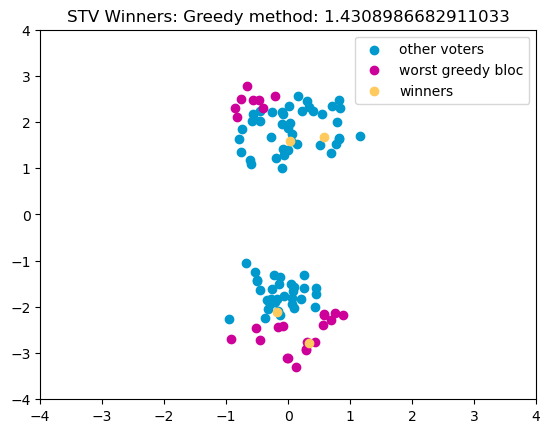

In [172]:
pal = sns.color_palette("hls", 8)
others = ~np.isin(range(n), worst_greedy_bloc)
plt.scatter(voter_positions[others,0], voter_positions[others,1], label = 'other voters', color = colors[0])
plt.scatter(voter_positions[worst_greedy_bloc,0], voter_positions[worst_greedy_bloc,1], label = 'worst greedy bloc', color = colors[4])
plt.scatter(candidate_positions[winners,0], candidate_positions[winners,1], label = 'winners', color = colors[1])
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.title(election + ' Winners: Greedy method: ' + str(np.round(worst_greedy_ineff, 5)))
plt.legend()

In [176]:
samples = 10000
worst_random_greedy_ineff = 0
worst_random_greedy_bloc = None
for _ in range(samples):
    random_ineff, random_bloc = random_greedy_group_inefficiency(dists, winners)
    
    if random_ineff > worst_random_greedy_ineff:
        worst_random_greedy_ineff = random_ineff
        worst_random_greedy_bloc = random_bloc

In [177]:
worst_random_greedy_ineff

1.1785953587695952

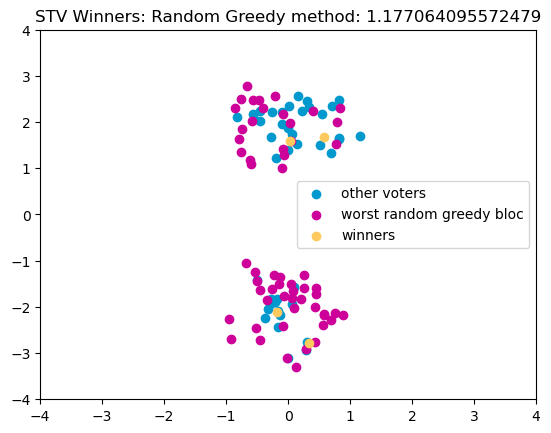

In [175]:
pal = sns.color_palette("hls", 8)
others = ~np.isin(range(n), worst_random_greedy_bloc)
plt.scatter(voter_positions[others,0], voter_positions[others,1], label = 'other voters', color = colors[0])
plt.scatter(voter_positions[worst_random_greedy_bloc,0], voter_positions[worst_random_greedy_bloc,1], label = 'worst random greedy bloc', color = colors[4])
plt.scatter(candidate_positions[winners,0], candidate_positions[winners,1], label = 'winners', color = colors[1])
plt.ylim(-4,4)
plt.xlim(-4,4)
plt.title(election + ' Winners: Random Greedy method: ' + str(np.round(worst_random_greedy_ineff, 5)))
plt.legend()